# Comparing CAD Part Models for Geometrical Similarity (Reproduction)

This notebook reproduces the **case-study workflow** of the paper using **synthetic CAD-like parts**. It follows the two-stage similarity approach:
1. **Global similarity** via spherical projection and correlation
2. **Local similarity** via supervised segmentation + DBSCAN clustering + normal-direction projection

Required visualizations: global similarity heatmap, segmentation + DBSCAN clusters, and a ranked retrieval table.

In [1]:
import sys
from pathlib import Path

root = Path().resolve()
if not (root / "cad_similarity").is_dir():
    if (root.parent / "cad_similarity").is_dir():
        root = root.parent
    elif (root.parent.parent / "cad_similarity").is_dir():
        root = root.parent.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

from cad_similarity.synthetic import generate_parts, sample_part, sample_surface
from cad_similarity.projection import spherical_projection
from cad_similarity.similarity import correlation_similarity, cluster_by_threshold
from cad_similarity.segmentation import build_features, train_models
from cad_similarity.clustering import dbscan_clusters
from cad_similarity.local_similarity import local_similarity

np.random.seed(42)

In [3]:
# Generate 6 synthetic parts: 3 groups x 2 samples
parts = generate_parts(seed=42)
[(p.name, p.group) for p in parts]

[('rect-0', 'rect'),
 ('rect-1', 'rect'),
 ('tri-0', 'tri'),
 ('tri-1', 'tri'),
 ('arc-0', 'arc'),
 ('arc-1', 'arc')]

In [4]:
# Sampling + normalization

def compute_center_scale(mesh):
    center = mesh.centroid
    scale = ((mesh.vertices - center) ** 2).sum(axis=1) ** 0.5
    scale = float(scale.max()) if len(scale) else 1.0
    if scale == 0:
        scale = 1.0
    return center, scale


def normalize_points(points, center, scale):
    centered = points - center
    return centered / scale

sampled = []
for part in parts:
    center, scale = compute_center_scale(part.full_mesh)

    # Global similarity uses full surface sampling (paper-consistent)
    g_pts, _ = sample_surface(part.full_mesh, n_points=2200, seed=42)
    g_pts = normalize_points(g_pts, center, scale)

    # Segmentation uses labeled samples
    pts, normals, labels = sample_part(part, n_base=1500, n_teeth=600, seed=42)
    pts = normalize_points(pts, center, scale)
    norms = (normals ** 2).sum(axis=1, keepdims=True) ** 0.5
    normals = np.divide(normals, norms, out=np.zeros_like(normals), where=norms != 0)

    sampled.append({
        "name": part.name,
        "group": part.group,
        "points": pts,
        "normals": normals,
        "labels": labels,
        "global_points": g_pts,
    })

len(sampled)

6

In [5]:
# Global spherical projection matrices
GLOBAL_BINS = (224, 224)

global_mats = [spherical_projection(item["global_points"], bins=GLOBAL_BINS) for item in sampled]

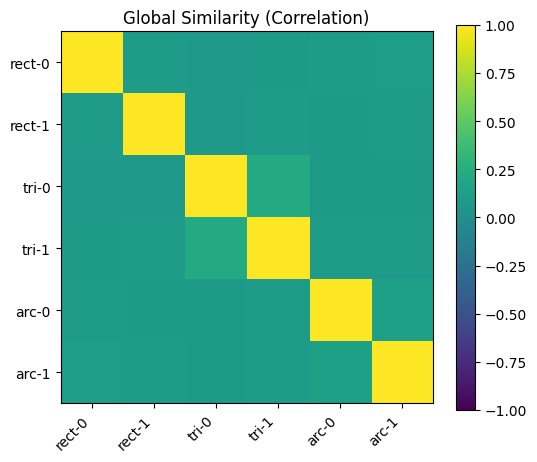

In [6]:
# Global similarity matrix
n = len(parts)
S = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        S[i, j] = correlation_similarity(global_mats[i], global_mats[j])

# Heatmap (required)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(S, cmap="viridis", vmin=-1, vmax=1)
ax.set_title("Global Similarity (Correlation)")
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels([p.name for p in parts], rotation=45, ha="right")
ax.set_yticklabels([p.name for p in parts])
fig.colorbar(im, ax=ax)
plt.show()

In [7]:
# Build segmentation dataset
X_list, y_list = [], []
for item in sampled:
    X = build_features(item["points"], item["normals"], k=8)
    X_list.append(X)
    y_list.append(item["labels"])

X_all = np.vstack(X_list)
y_all = np.hstack(y_list)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=42, stratify=y_all
)

models = train_models(X_train, y_train, seed=42)
acc = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}
acc

{'decision_tree': 0.9768253968253968, 'mlp': 0.9990476190476191}

In [8]:
# Choose best model for downstream
best_name = max(acc, key=acc.get)
best_model = models[best_name]
print("Best model:", best_name, "accuracy:", acc[best_name])

# Predict labels for each part
for item in sampled:
    X = build_features(item["points"], item["normals"], k=8)
    item["pred_labels"] = best_model.predict(X)

Best model: mlp accuracy: 0.9990476190476191


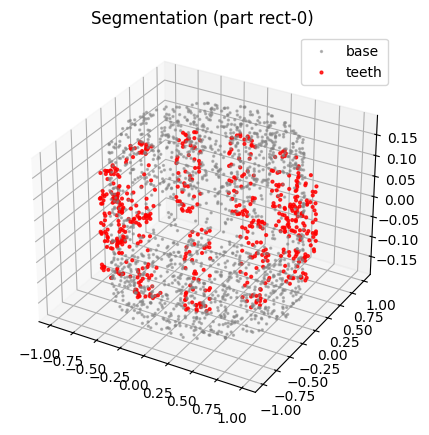

In [9]:
# Segmentation visualization (required)
idx = 0
item = sampled[idx]
pts = item["points"]
labels = item["pred_labels"]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pts[labels == 0, 0], pts[labels == 0, 1], pts[labels == 0, 2], s=2, c="gray", alpha=0.5, label="base")
ax.scatter(pts[labels == 1, 0], pts[labels == 1, 1], pts[labels == 1, 2], s=4, c="red", alpha=0.8, label="teeth")
ax.set_title(f"Segmentation (part {item['name']})")
ax.legend()
plt.show()

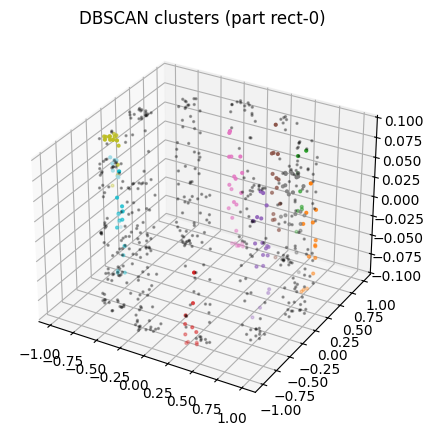

In [10]:
# DBSCAN clustering on predicted teeth (required)
item = sampled[idx]
mask = item["pred_labels"] == 1
teeth_pts = item["points"][mask]

if len(teeth_pts) > 10:
    nn = NearestNeighbors(n_neighbors=5).fit(teeth_pts)
    dists, _ = nn.kneighbors(teeth_pts)
    eps = float(dists[:, 1:].mean() * 1.5)
else:
    eps = 0.05

cluster_labels = dbscan_clusters(teeth_pts, eps=eps, min_samples=10)
item["tooth_clusters"] = cluster_labels

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
unique = sorted(set(cluster_labels))
colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(unique))))
for c, col in zip(unique, colors):
    idxs = cluster_labels == c
    if c == -1:
        ax.scatter(teeth_pts[idxs, 0], teeth_pts[idxs, 1], teeth_pts[idxs, 2], s=2, c="black", alpha=0.3, label="noise")
    else:
        ax.scatter(teeth_pts[idxs, 0], teeth_pts[idxs, 1], teeth_pts[idxs, 2], s=4, color=col, label=f"cluster {c}")
ax.set_title(f"DBSCAN clusters (part {item['name']})")
plt.show()

In [11]:
# Prepare local similarity matrices for each part
local_cluster_mats = []
for item in sampled:
    mask = item["pred_labels"] == 1
    teeth_pts = item["points"][mask]
    teeth_normals = item["normals"][mask]

    if len(teeth_pts) > 10:
        nn = NearestNeighbors(n_neighbors=5).fit(teeth_pts)
        dists, _ = nn.kneighbors(teeth_pts)
        eps = float(dists[:, 1:].mean() * 1.5)
        cluster_labels = dbscan_clusters(teeth_pts, eps=eps, min_samples=10)
    else:
        cluster_labels = np.array([-1] * len(teeth_pts))

    mats = []
    for c in sorted(set(cluster_labels)):
        if c == -1:
            continue
        idxs = cluster_labels == c
        if idxs.sum() < 10:
            continue
        mats.append(spherical_projection(teeth_normals[idxs], bins=GLOBAL_BINS))
    local_cluster_mats.append(mats)

In [12]:
# Ranking example (required)
query = 0
order = np.argsort(S[query])[::-1]

sims_sorted = [S[query, i] for i in order]
clusters = cluster_by_threshold(sims_sorted, threshold=0.01)

ranking = []
for cluster in clusters:
    indices = [order[i] for i in cluster]
    if len(indices) == 1:
        ranking.append(indices[0])
    else:
        local_scores = {}
        for idx2 in indices:
            local_scores[idx2] = local_similarity(local_cluster_mats[query], local_cluster_mats[idx2])
        indices_sorted = sorted(indices, key=lambda i: local_scores[i], reverse=True)
        ranking.extend(indices_sorted)

rows = []
for rank, idx2 in enumerate(ranking, start=1):
    rows.append([
        rank,
        parts[idx2].name,
        parts[idx2].group,
        float(S[query, idx2]),
        float(local_similarity(local_cluster_mats[query], local_cluster_mats[idx2]))
    ])

rows[:6]

[[1, 'rect-0', 'rect', 1.0, 1.0],
 [2, 'arc-1', 'arc', 0.11744255926268778, 0.3611032674917014],
 [3, 'rect-1', 'rect', 0.10148510477287738, 0.33399458404310134],
 [4, 'tri-1', 'tri', 0.0929724502870992, 0.25823605374438446],
 [5, 'arc-0', 'arc', 0.0992700956057375, 0.22914898401638586],
 [6, 'tri-0', 'tri', 0.08311549157499781, 0.13863227736520414]]

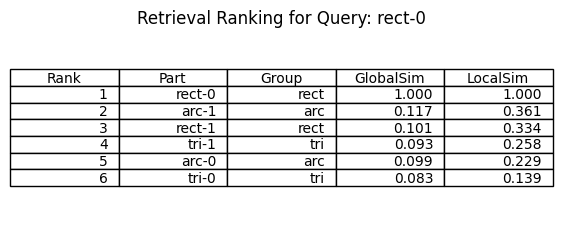

In [13]:
# Display ranking table
fig, ax = plt.subplots(figsize=(7, 2.5))
ax.axis('off')
col_labels = ["Rank", "Part", "Group", "GlobalSim", "LocalSim"]
cell_text = [[r[0], r[1], r[2], f"{r[3]:.3f}", f"{r[4]:.3f}"] for r in rows]
ax.table(cellText=cell_text, colLabels=col_labels, loc='center')
ax.set_title(f"Retrieval Ranking for Query: {parts[query].name}")
plt.show()

In [14]:
# Summary of key parameters
params = {
    "global_bins": GLOBAL_BINS,
    "n_base": 1500,
    "n_teeth": 600,
    "cluster_threshold": 0.01,
    "segmentation_model": best_name,
}
params

{'global_bins': (224, 224),
 'n_base': 1500,
 'n_teeth': 600,
 'cluster_threshold': 0.01,
 'segmentation_model': 'mlp'}